## Evaluation notebook

### 1. Load packages we need, and RMSE function

In [1]:
import geopandas as gpd
from sklearn.metrics import root_mean_squared_error

### 2. Read and clean data

In [2]:
# read real building height value
shapefile_path = "../assets/downtown_clipped_buildings_real.shp"
clipped_buildings_gdf = gpd.read_file(shapefile_path)
clipped_buildings_gdf["ground truth bh value"] = clipped_buildings_gdf["dd_h_dak_m"] - clipped_buildings_gdf["h_maaiveld"] 

# read estimated building height value
predict_gdf = gpd.read_file("../assets/downtown_wageningen_estimated.json")

# check the nan value
print("nan value: ", "clipped_buildings_gdf nan: ", \
      clipped_buildings_gdf["ground truth bh value"].isnull().sum(), \
      "predict_gdf nan: ", \
        predict_gdf["MeanValue"].isnull().sum())

nan value:  clipped_buildings_gdf nan:  127 predict_gdf nan:  10


In [3]:
# clean nan value
null_index_1 = clipped_buildings_gdf[clipped_buildings_gdf["ground truth bh value"].isnull()].index
clipped_buildings_gdf_1 = clipped_buildings_gdf.drop(null_index_1)
predict_gdf_1 = predict_gdf.drop(null_index_1)
null_index_2 = predict_gdf_1[predict_gdf_1["MeanValue"].isnull()].index
clipped_buildings_gdf_2 = clipped_buildings_gdf_1.drop(null_index_2)
predict_gdf_2 = predict_gdf_1.drop(null_index_2)

In [4]:
# calculate error percentage
error_percentage = abs(abs(abs(clipped_buildings_gdf_2["ground truth bh value"]) - abs(predict_gdf_2["MeanValue"])) / clipped_buildings_gdf_2["ground truth bh value"]) * 100
error_percentage

0       40.178087
1       16.614988
2       48.923293
3        7.392631
4        7.824386
          ...    
2457     3.846711
2458    15.057191
2459    62.843415
2460     5.290192
2461    74.695092
Length: 2325, dtype: float64

In [5]:
cleaned_gdf = gpd.GeoDataFrame({
    "geometry": clipped_buildings_gdf_2.geometry,  # 
    "ground truth bh value": clipped_buildings_gdf_2["ground truth bh value"],
    "edtimated bh meanvalue": predict_gdf_2["MeanValue"],
    "error_percentage": error_percentage
}, geometry="geometry")

cleaned_gdf = cleaned_gdf[(cleaned_gdf["error_percentage"] >= 0) & (cleaned_gdf["error_percentage"] <= 100)]

print(cleaned_gdf.head())

                                            geometry  ground truth bh value  \
0  POLYGON ((173718.354 441616.530, 173718.907 44...               2.584549   
1  POLYGON ((173732.856 441616.374, 173732.475 44...               3.346144   
2  POLYGON ((173763.392 441612.702, 173761.278 44...               2.226685   
3  POLYGON ((173737.635 441619.865, 173742.761 44...               4.045308   
4  POLYGON ((173742.767 441620.823, 173748.045 44...               4.080865   

   edtimated bh meanvalue  error_percentage  
0                3.622971         40.178087  
1                3.902105         16.614988  
2                3.316052         48.923293  
3                3.746253          7.392631  
4                4.400168          7.824386  


In [6]:
rmse = root_mean_squared_error(cleaned_gdf["ground truth bh value"], cleaned_gdf["edtimated bh meanvalue"])
rmse
# print("RMSE: ", rmse) # RMSE:  2.009186365152395

1.6110928426146456

### 3. Exploratory data analysis (EDA): Draw line chart

In [7]:
import matplotlib.pyplot as plt

In [8]:
# Replace these with the actual values from clipped_buildings_gdf_2 and predict_gdf_2
ground_truth_value = cleaned_gdf["ground truth bh value"]
estimated_value = cleaned_gdf["edtimated bh meanvalue"]

# Generate the x-axis (index)
x_axis = range(1, len(ground_truth_value) + 1)

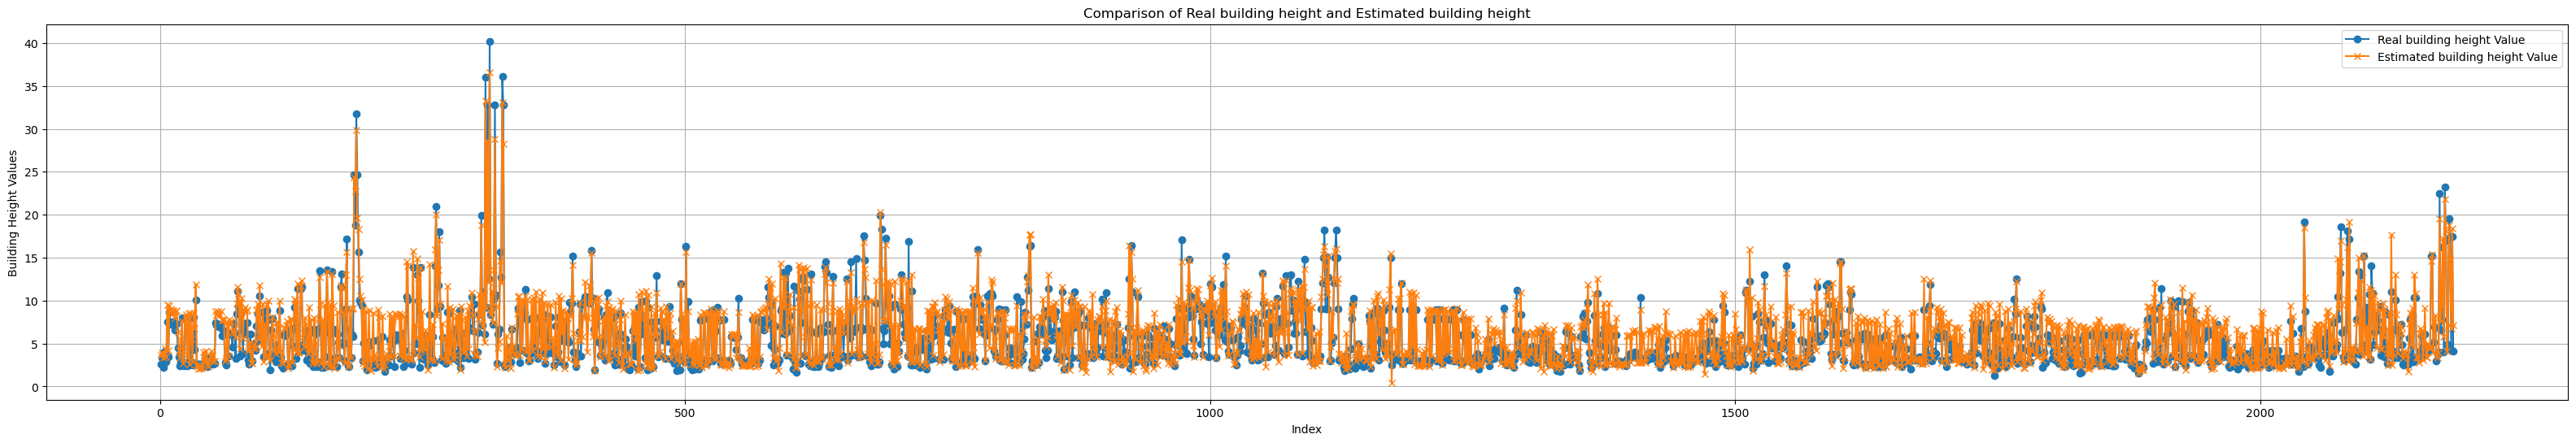

In [9]:
# Plotting the line graph
plt.figure(figsize=(40, 6))
plt.plot(x_axis, ground_truth_value, label="Real building height Value", marker='o')
plt.plot(x_axis, estimated_value, label="Estimated building height Value", marker='x')

# Adding labels and title
plt.xlabel('Index')
plt.ylabel('Building Height Values')
plt.title('Comparison of Real building height and Estimated building height')
plt.legend()

# Display the plot
plt.grid(True)
plt.show()

### 4. Visualize height difference distribution map

In [10]:
import os

In [11]:
cleaned_gdf["height_difference"] = cleaned_gdf["ground truth bh value"] - cleaned_gdf["edtimated bh meanvalue"]
cleaned_gdf["absolute_difference"] = abs(cleaned_gdf["ground truth bh value"] - cleaned_gdf["edtimated bh meanvalue"])

cleaned_gdf["height_difference"] 

0      -1.038422
1      -0.555961
2      -1.089367
3       0.299055
4      -0.319303
          ...   
2457    0.752024
2458    2.618508
2459   -2.622775
2460   -0.923234
2461   -3.066288
Name: height_difference, Length: 2184, dtype: float64

In [12]:
legend_kwds= {
  'loc': 'upper right',
  'bbox_to_anchor': (1.1, 1),
  'fmt': '{:<5.0f}',
  'frameon': False,
  'fontsize': 8,
  'title': 'height difference (m)'
}
classification_kwds={
  'bins':[-4, -3, -2, -1, 0, 1, 2, 3, 4, 5]
}

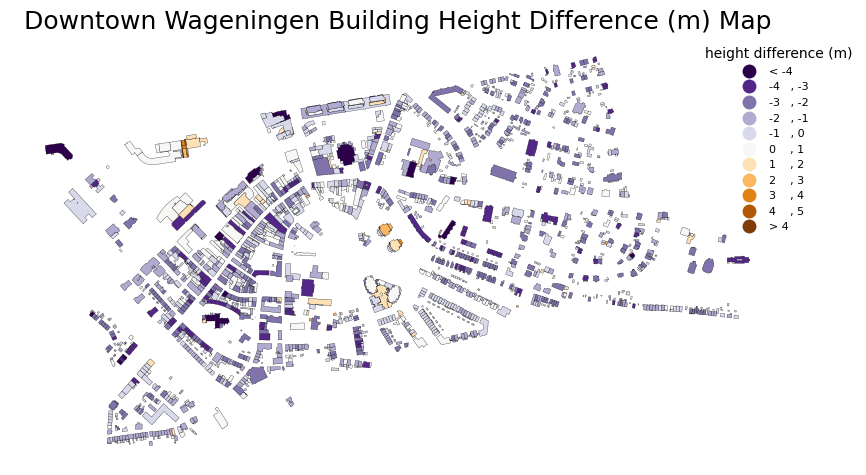

In [13]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(10,10)
cleaned_gdf.plot(ax=ax, column='height_difference', cmap='PuOr_r', scheme='User_Defined',
         classification_kwds=classification_kwds,
         legend=True, legend_kwds=legend_kwds,
        edgecolor='black', linewidth=0.2)

ax.set_axis_off()

# Change the last entry in the legend to '>5000'
legend = ax.get_legend()
legend.texts[0].set_text('< -4')
legend.texts[-1].set_text('> 4')

# Add a title
ax.set_title('Downtown Wageningen Building Height Difference (m) Map', size = 18)

output_folder = "../assets"
output_path = os.path.join(output_folder, 'downtown_wageningen_height_difference_map.svg')
plt.savefig(output_path, dpi=640, bbox_inches='tight', transparent=True)

plt.show()

In [19]:
legend_kwds= {
  'loc': 'upper right',
  'bbox_to_anchor': (1.1, 1),
  'fmt': '{:<5.1f}',
  'frameon': False,
  'fontsize': 8,
  'title': 'absolute height difference (m)'
}
classification_kwds={
  'bins':[0.5, 1, 1.5, 2.5, 3, 4]
}

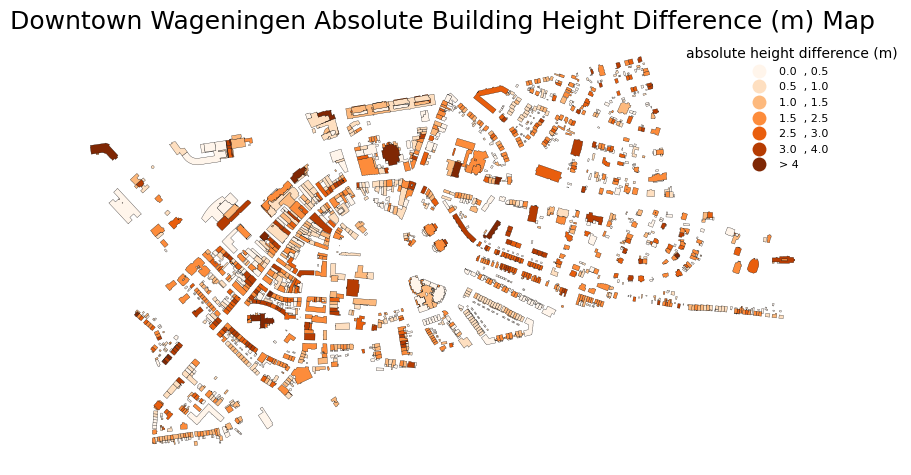

In [20]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(10,10)
cleaned_gdf.plot(ax=ax, column='absolute_difference', cmap='Oranges', scheme='User_Defined',
         classification_kwds=classification_kwds,
         legend=True, legend_kwds=legend_kwds,
        edgecolor='black', linewidth=0.2)

ax.set_axis_off()

# Change the last entry in the legend to '>5000'
legend = ax.get_legend()
legend.texts[-1].set_text('> 4')

# Add a title
ax.set_title('Downtown Wageningen Absolute Building Height Difference (m) Map', size = 18)

output_folder = "../assets"
output_path = os.path.join(output_folder, 'downtown_wageningen_absolute_height_difference_map.svg')
plt.savefig(output_path, dpi=640, bbox_inches='tight', transparent=True)

plt.show()

### 5. Visualize error distribution map

In [16]:
import os

In [17]:
legend_kwds= {
  'loc': 'upper right',
  'bbox_to_anchor': (1.1, 1),
  'fmt': '{:<5.0f}',
  'frameon': False,
  'fontsize': 8,
  'title': 'error percentage (%)'
}
classification_kwds={
  'bins':[1, 5, 10, 25, 50, 100]
}

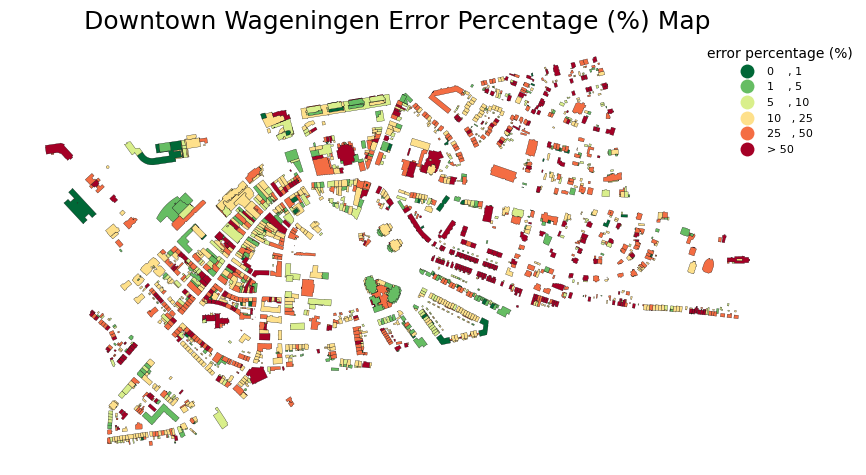

In [18]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(10,10)
cleaned_gdf.plot(ax=ax, column='error_percentage', cmap='RdYlGn_r', scheme='User_Defined',
         classification_kwds=classification_kwds,
         legend=True, legend_kwds=legend_kwds,
            edgecolor='black', linewidth=0.2)

ax.set_axis_off()

# Change the last entry in the legend to '>5000'
legend = ax.get_legend()
legend.texts[-1].set_text('> 50')

# Add a title
ax.set_title('Downtown Wageningen Error Percentage (%) Map', size = 18)

output_folder = "../assets"
output_path = os.path.join(output_folder, 'downtown_wageningen_error_map.svg')
plt.savefig(output_path, dpi=640, bbox_inches='tight', transparent=True)

plt.show()